In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#load the dataset


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bitsecure/all_three.csv')


# Drop unnecessary columns

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'block_id'])

# Handle missing values

In [ ]:
df.fillna(df.median(), inplace=True)

# Feature Engineering

In [ ]:
df['fee_ratio'] = df['fee'] / (df['amount'] + 1e-6)
df['input_output_ratio'] = df['input_total'] / (df['output_total'] + 1e-6)
df['balance_change'] = df['input_total'] - df['output_total']



# Normalize numeric columns

In [ ]:
scaler = MinMaxScaler()
numeric_cols = ['balance', 'amount', 'fee', 'input_total', 'output_total', 'fee_ratio', 'input_output_ratio']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Handle class imbalance

In [ ]:
X = df.drop(columns=['label'])
y = df['label']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


# Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=40)


# Convert data to PyTorch tensors

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


# Create DataLoader

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Defining LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [ ]:
print(y_train_tensor.unique())
print(y_test_tensor.unique())


tensor([0, 1, 2, 3])
tensor([0, 1, 2, 3])


# Model initialization

In [ ]:
lstm_model = LSTMModel(input_size=X_train.shape[1], hidden_size=64, num_layers=2, output_size=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training LSTM Model

In [ ]:
def train_lstm(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

train_lstm(lstm_model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.5781
Epoch 2/10, Loss: 0.5900
Epoch 3/10, Loss: 0.8261
Epoch 4/10, Loss: 0.3538
Epoch 5/10, Loss: 0.5538
Epoch 6/10, Loss: 0.4039
Epoch 7/10, Loss: 0.5159
Epoch 8/10, Loss: 0.6246
Epoch 9/10, Loss: 0.6955
Epoch 10/10, Loss: 0.8734


In [ ]:
print(y_train_tensor.unique())
print(y_test_tensor.unique())


tensor([0, 1, 2, 3])
tensor([0, 1, 2, 3])


In [ ]:
# Evaluate LSTM Model
def evaluate_lstm(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    print(classification_report(all_labels, all_preds))
    print("AUC-ROC Score:", roc_auc_score(all_labels, all_preds))

evaluate_lstm(lstm_model, test_loader)


In [ ]:
# Train traditional models
xgb = XGBClassifier()
rf = RandomForestClassifier()
ensemble_model = VotingClassifier(estimators=[('xgb', xgb), ('rf', rf)], voting='soft')
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)


In [ ]:
import numpy as np

y_test = np.array(y_test)
y_pred = np.array(y_pred)

print("y_test shape:", y_test.shape, "y_pred shape:", y_pred.shape)
print("y_test dtype:", y_test.dtype, "y_pred dtype:", y_pred.dtype)


y_test shape: (268678,) y_pred shape: (268678,)
y_test dtype: int64 y_pred dtype: int64


In [ ]:
y_pred = y_pred.flatten()


In [ ]:
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_test: [0 1 2 3]
Unique values in y_pred: [0 1 2 3]


In [ ]:
from sklearn.metrics import classification_report

labels = np.unique(np.concatenate([y_test, y_pred]))  # Get all unique labels
print(classification_report(y_test, y_pred, labels=labels))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     66597
           1       1.00      1.00      1.00     67663
           2       1.00      1.00      1.00     67128
           3       0.98      1.00      0.99     67290

    accuracy                           0.99    268678
   macro avg       0.99      0.99      0.99    268678
weighted avg       0.99      0.99      0.99    268678



In [ ]:
y_pred_scores = ensemble_model.predict_proba(X_test)  # Use predict_proba instead of decision_function
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_scores, multi_class='ovr'))


AUC-ROC Score: 0.9999032888335594


<Axes: xlabel='label', ylabel='count'>

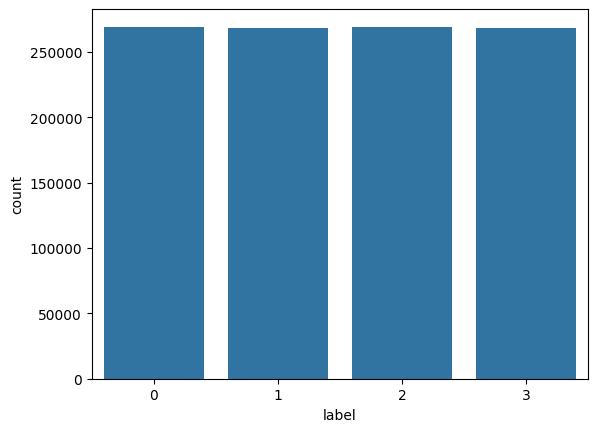

In [ ]:
import seaborn as sns

# Count instances in each class
sns.countplot(x=y_train)



In [ ]:
train_accuracy = ensemble_model.score(X_train, y_train)
test_accuracy = ensemble_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




Training Accuracy: 0.9976
Test Accuracy: 0.9948


In [ ]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities (not class labels)
y_pred_probs = ensemble_model.predict_proba(X_test)

# Compute AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"AUC-ROC Score: {auc_score:.4f}")


AUC-ROC Score: 0.9999


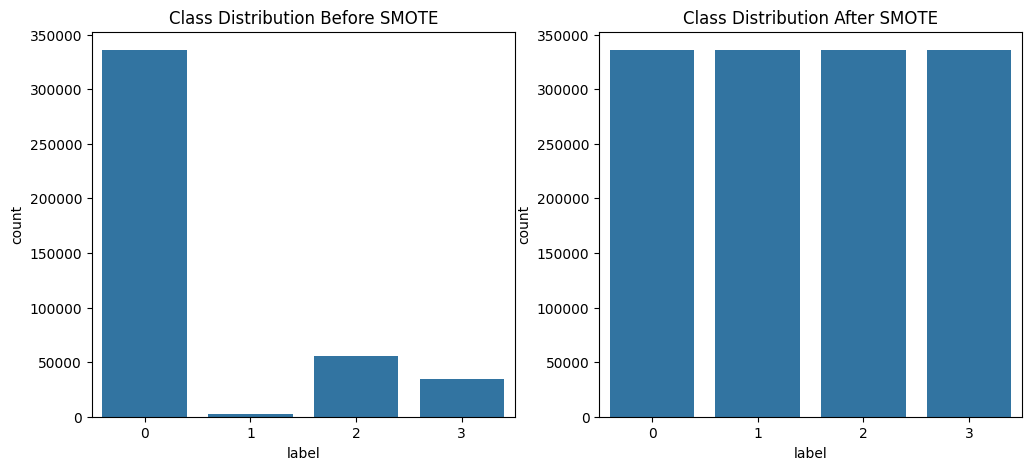

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before SMOTE")

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE")

plt.show()